# Experiment 3: Missing Data

The issue we have encountered is that when there is missing data in one channel in a context set, the other channels have their values set to zero at the same locations. The density map then shows no data at these locations. We would prefer that this does not happen - i.e. the non-missing values are not set to zero. But this may violate the underlying mechanics of the ConvNP. In this experiment, we investigate what is going on.

First, set up the environment

In [1]:
%load_ext autoreload

In [2]:
# imports
%autoreload 2
from convcnp_assim_nz.utils.variables.var_names import *
from convcnp_assim_nz.utils.variables.coord_names import *
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import *
from convcnp_assim_nz.config.env_loader import get_env_var, use_absolute_filepaths
from convcnp_assim_nz.learning.model_training import batch_data_by_num_stations, compute_val_loss
from convcnp_assim_nz.data_processing.station_processor import ProcessStations
from convcnp_assim_nz.data_processing.topography_processor import ProcessTopography
from convcnp_assim_nz.data_processing.era5_processor import ProcessERA5
from convcnp_assim_nz.data_processing.auxiliary.sun_position import get_sun_culmination, get_sun_position

In [3]:
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device, concat_tasks
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from mpl_toolkits.basemap import Basemap
import torch
from torch import optim
import os
import lab as B
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf
import gc

In [4]:
# set to use absolute filepaths
# this is needed when data isn't stored relative to DATA_HOME
# you would likely not set this to true if using a university or personal computer with data stored tidily in a data directory
use_absolute_filepaths(mode=True)

### Build a small dataset for some sample tasks
While we are going to build a model (necessary for inspecting encoded tasks) we are not going to train it - so the dataset does not need to be large.

In [5]:
#station_processor = ProcessStations()
topography_processor = ProcessTopography()
era5_processor = ProcessERA5()

In [6]:
# clean up the ERA5 data:
# get variable filters a dataset to a single variable dataarray
era5_ds = era5_processor.load_ds(mode="surface", years=[2014], standardise_var_names=True, standardise_coord_names=True)
era5_var = era5_processor.get_variable(era5_ds, TEMPERATURE) # set variable to process - e.g. "temperature"
era5_var = kelvin_to_celsius(era5_var)
era5_ds[TEMPERATURE] = era5_var

# add sun culmination context to the dataset
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)
era5_ds[SUN_ANGLE] = get_sun_position(era5_ds.coords)

# sea surface temperature contains missing values over land
era5_ds = era5_ds[[TEMPERATURE, SURFACE_PRESSURE, SEA_SURFACE_TEMPERATURE, SUN_CULMINATION, SUN_ANGLE]]
era5_ds_coarsen = era5_ds.coarsen({LATITUDE: 2, LONGITUDE: 2}, boundary="trim").mean() # we can coarsen lots because we aren't doing training

In [6]:
# build a small auxiliary dataset with topography and TPI
topography_ds = topography_processor.load_ds(standardise_var_names=True, standardise_coord_names=True)
ds_aux = topography_processor.compute_tpi(topography_ds, window_sizes=[0.1])

AUXILIARY_COARSEN_FACTOR = 200
ds_aux_coarse  = ds_aux.coarsen(
    lat=AUXILIARY_COARSEN_FACTOR, 
    lon=AUXILIARY_COARSEN_FACTOR, 
    boundary='trim').mean()

# fill NAs on topography - but it could be interesting to see what happens if we don't
ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

In [8]:
# load the stations with the variable of interest between the start and end years
stations_df = station_processor.load_df(vars=[TEMPERATURE], year_start=2014, year_end=2014)
stations_df.head()
stations_reset = stations_df.reset_index()
stations_reset.drop(columns=['station'], inplace=True)

# resample to six-hourly frequency to match ERA5 timestamps
stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[[TEMPERATURE]]
stations_resample = stations_resample.reset_index().set_index(['time', 'lat', 'lon']).sort_index()

# drop station gisborne aero aws (too close to other station)
drop_lat, drop_lon = -38.66100, 177.98600

stations_resample = stations_resample[~((stations_resample.index.get_level_values('lat') == drop_lat) 
                                        & (stations_resample.index.get_level_values('lon') == drop_lon))]

/home/lennoxc/niwa/convcnp-assim-nz/src/data_processing/station_processor.py:157: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds_comb = xr.concat([first, *station_iter], dim="station")
/tmp/ipykernel_4207/2885994788.py:8: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[[TEMPERATURE]]


In [9]:
# data pre-processing
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))
era5_processed, station_processed = data_processor([era5_ds_coarsen, stations_resample])
ds_aux_processed, ds_aux_coarse_processed = data_processor([ds_aux, ds_aux_coarse], method='min_max')

x1x2_ds = construct_x1x2_ds(ds_aux_coarse_processed)
ds_aux_coarse_processed['x1_arr'] = x1x2_ds['x1_arr']
ds_aux_coarse_processed['x2_arr'] = x1x2_ds['x2_arr']

task_loader = TaskLoader(
        context = [station_processed, era5_processed, ds_aux_coarse_processed], 
        target = station_processed, 
        aux_at_targets = ds_aux_processed, 
        links = [(0, 0)])

# build a model - necessary to visualise context encodings
# we won't train it in this experiment
model = ConvNP(data_processor, task_loader, unet_channels=(64,)*5, likelihood="gnp")

/home/lennoxc/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"x1_map={x1_map} and x2_map={x2_map} have different ranges ({float(np.diff(x1_map))} "
/home/lennoxc/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"and {float(np.diff(x2_map))}, respectively). "
/home/lennoxc/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:128: UserWarning: x1_map=(-50.0, -32.0) and x2_map=(165.0, 180.0) have different ranges (18.0 and 15.0, respectively). This can lead to stretching/squas

dim_yc inferred from TaskLoader: (1, 5, 4)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 2
Setting aux_t_mlp_layers: (64, 64, 64)
internal_density inferred from TaskLoader: 70
encoder_scales inferred from TaskLoader: [0.007142857142857143, 0.01388888992369175, 0.007111109793186188]
decoder_scale inferred from TaskLoader: 0.014285714285714285


In [10]:
# build a set of tasks to investigate
train_dates = era5_ds.sel(time=slice("2014-01-01", "2014-12-31")).time.values

train_tasks = []
for date in train_dates:
    task = task_loader(date, context_sampling=["split", "all", "all"], target_sampling=["split"], split_frac=0.5)
    train_tasks.append(task)

## Demonstrating the problem
When plotting the task, you can see that context set 1 sea surface temperature channel contains missing values in context set 1.

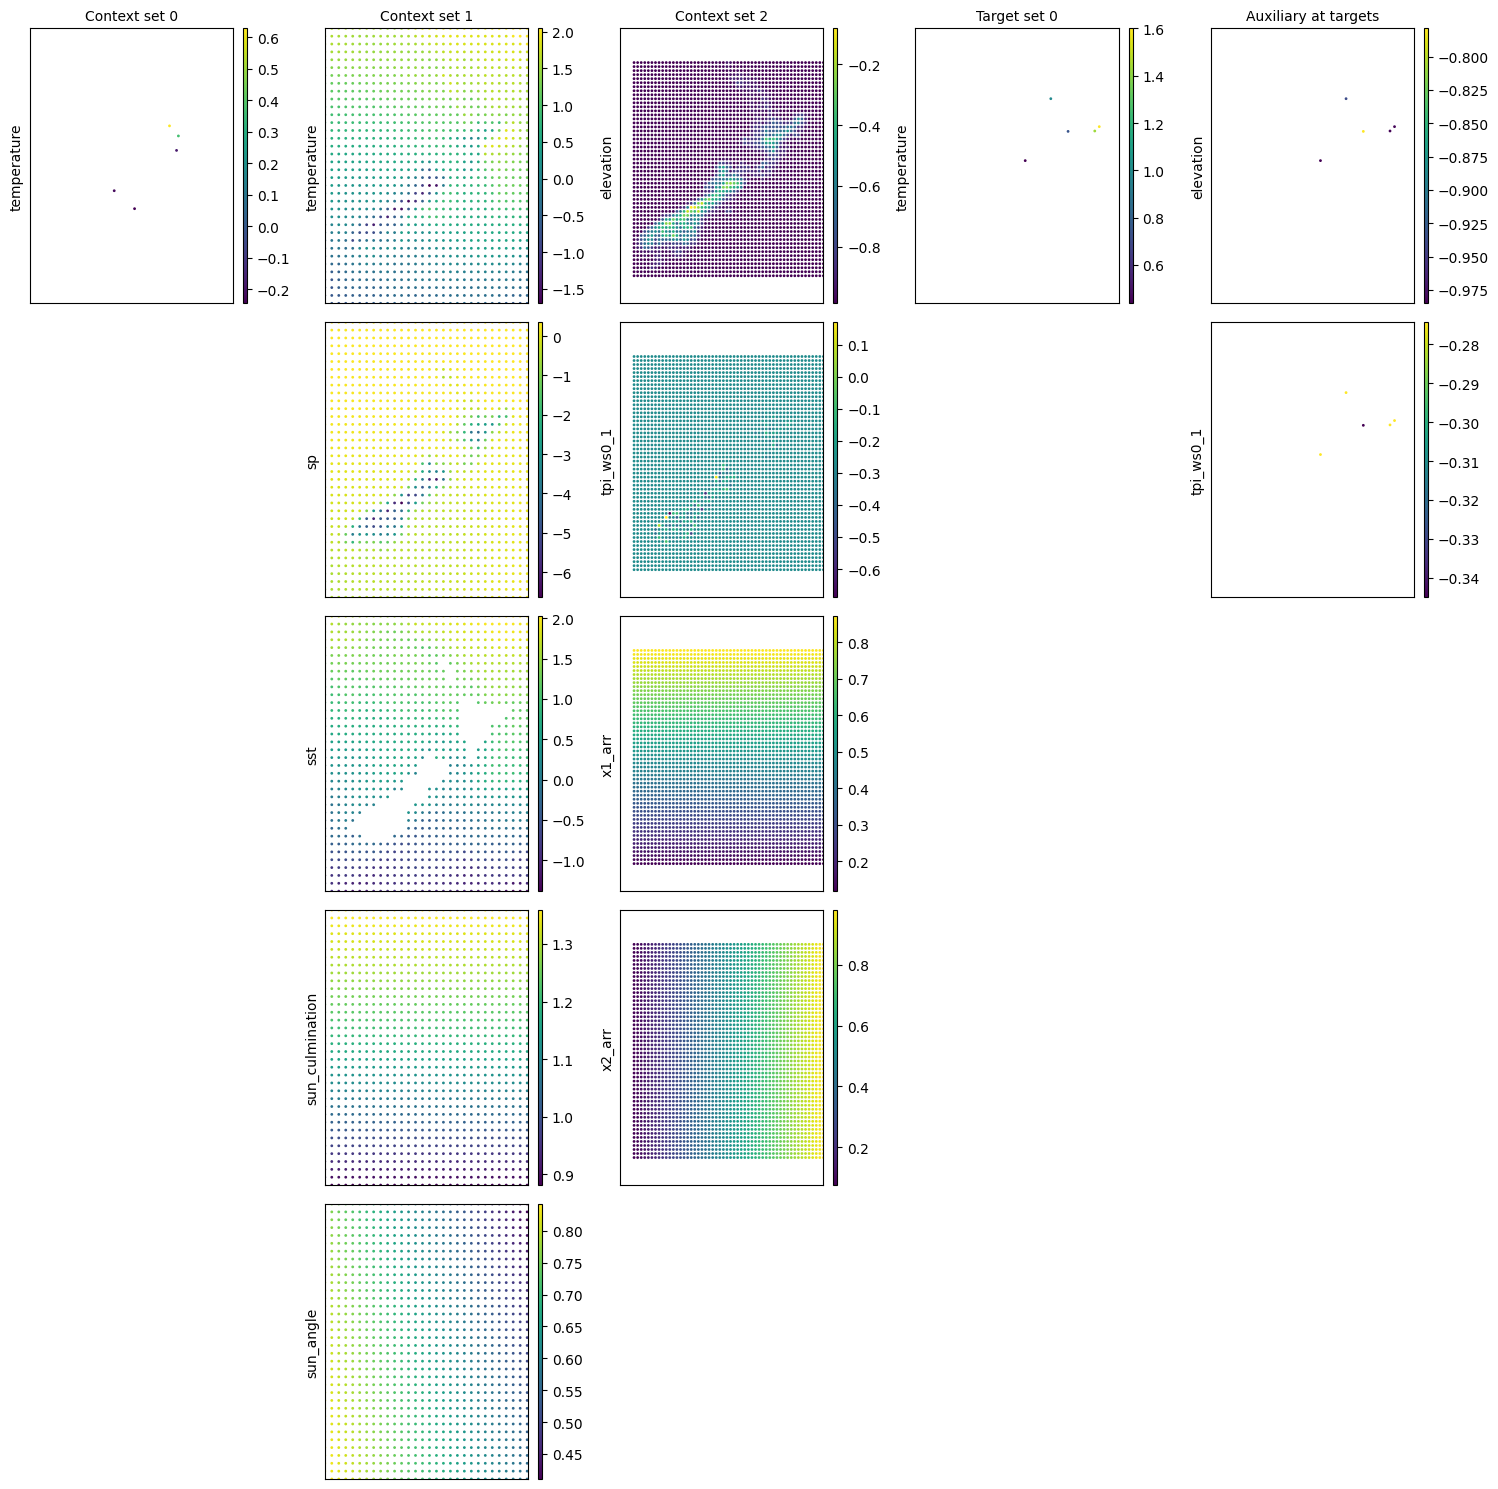

In [11]:
# this shows a single task and the data contained
plot = deepsensor.plot.task(train_tasks[1], task_loader)
plot.show()

When the context set is converted to an encoding for the model, there are missing values in sea-surface temperature, which affect all the other channels.

In [12]:
plot= deepsensor.plot.context_encoding(model, train_tasks[1], task_loader)
plot.show()

/home/lennoxc/niwa/convcnp-assim-nz/venv/lib/python3.12/site-packages/lab/types.py:204: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


We are concerned about the models ability to make predictions on a context set with data missing from many channels. We want it to be more resiliant to missing data.

In [13]:
from copy import deepcopy
task = deepcopy(train_tasks[1])

In [14]:
train_tasks[1]

time: Timestamp/2014-01-01 06:00:00
ops: []
X_c: ['ndarray/float32/(2, 5)', ('ndarray/float32/(1, 36)', 'ndarray/float32/(1, 30)'), ('ndarray/float32/(1, 54)', 'ndarray/float32/(1, 54)')]
Y_c: ['ndarray/float32/(1, 5)', 'ndarray/float32/(5, 36, 30)', 'ndarray/float32/(4, 54, 54)']
X_t: ['ndarray/float32/(2, 5)']
Y_t: ['ndarray/float32/(1, 5)']
Y_t_aux: ndarray/float32/(2, 5)

True


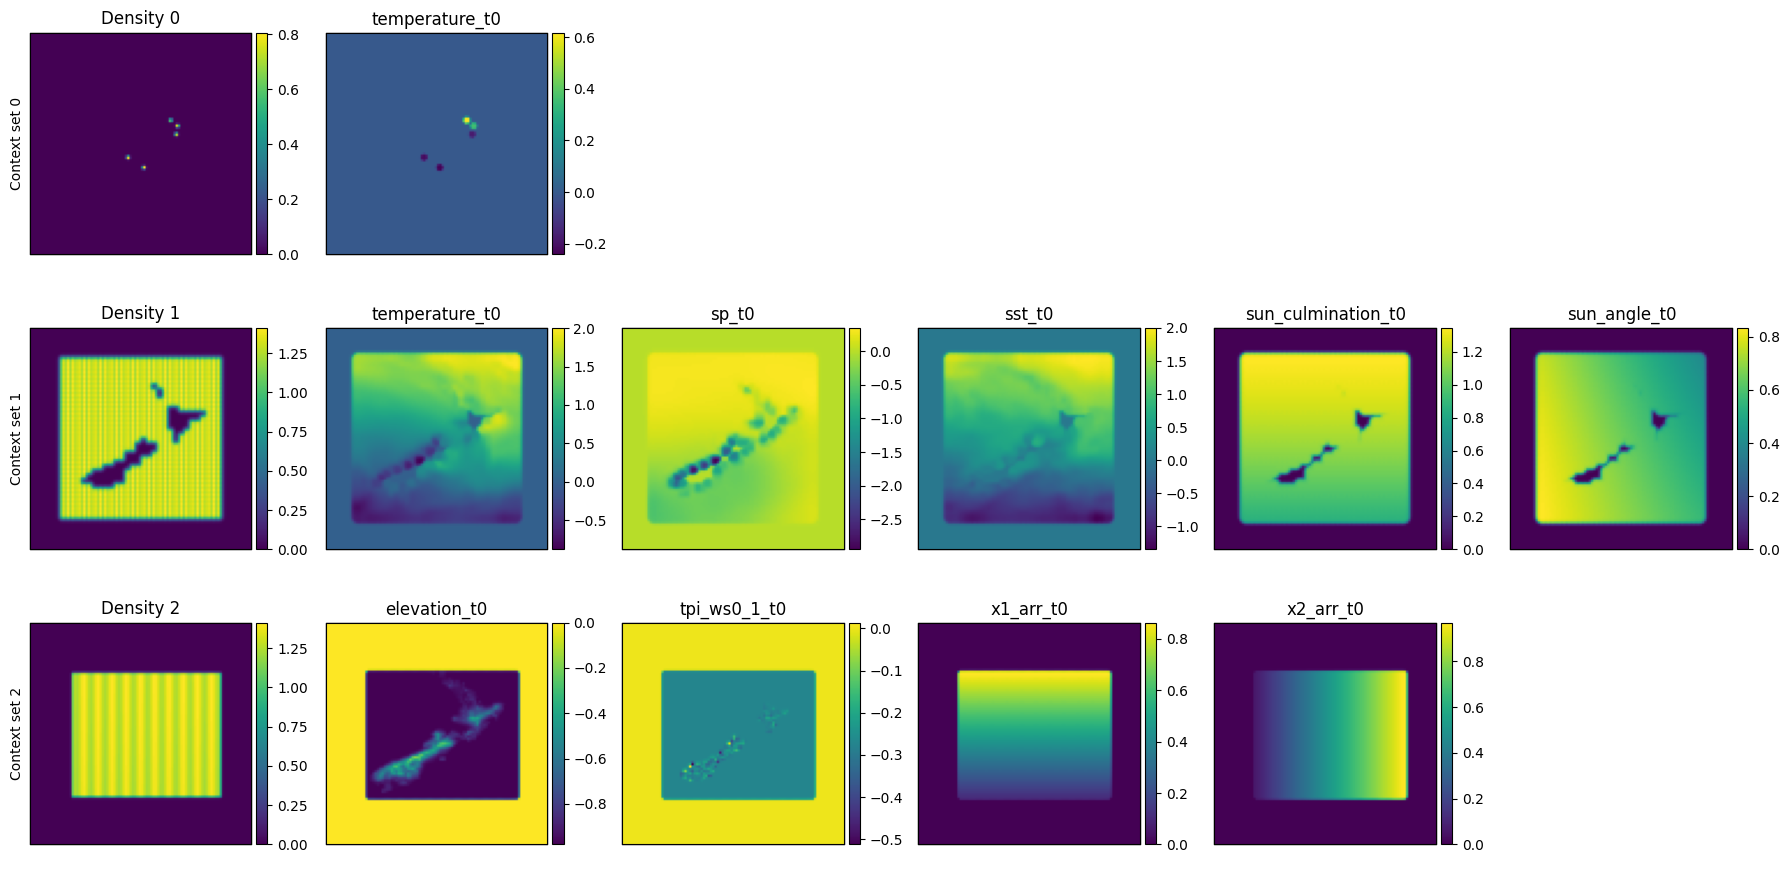

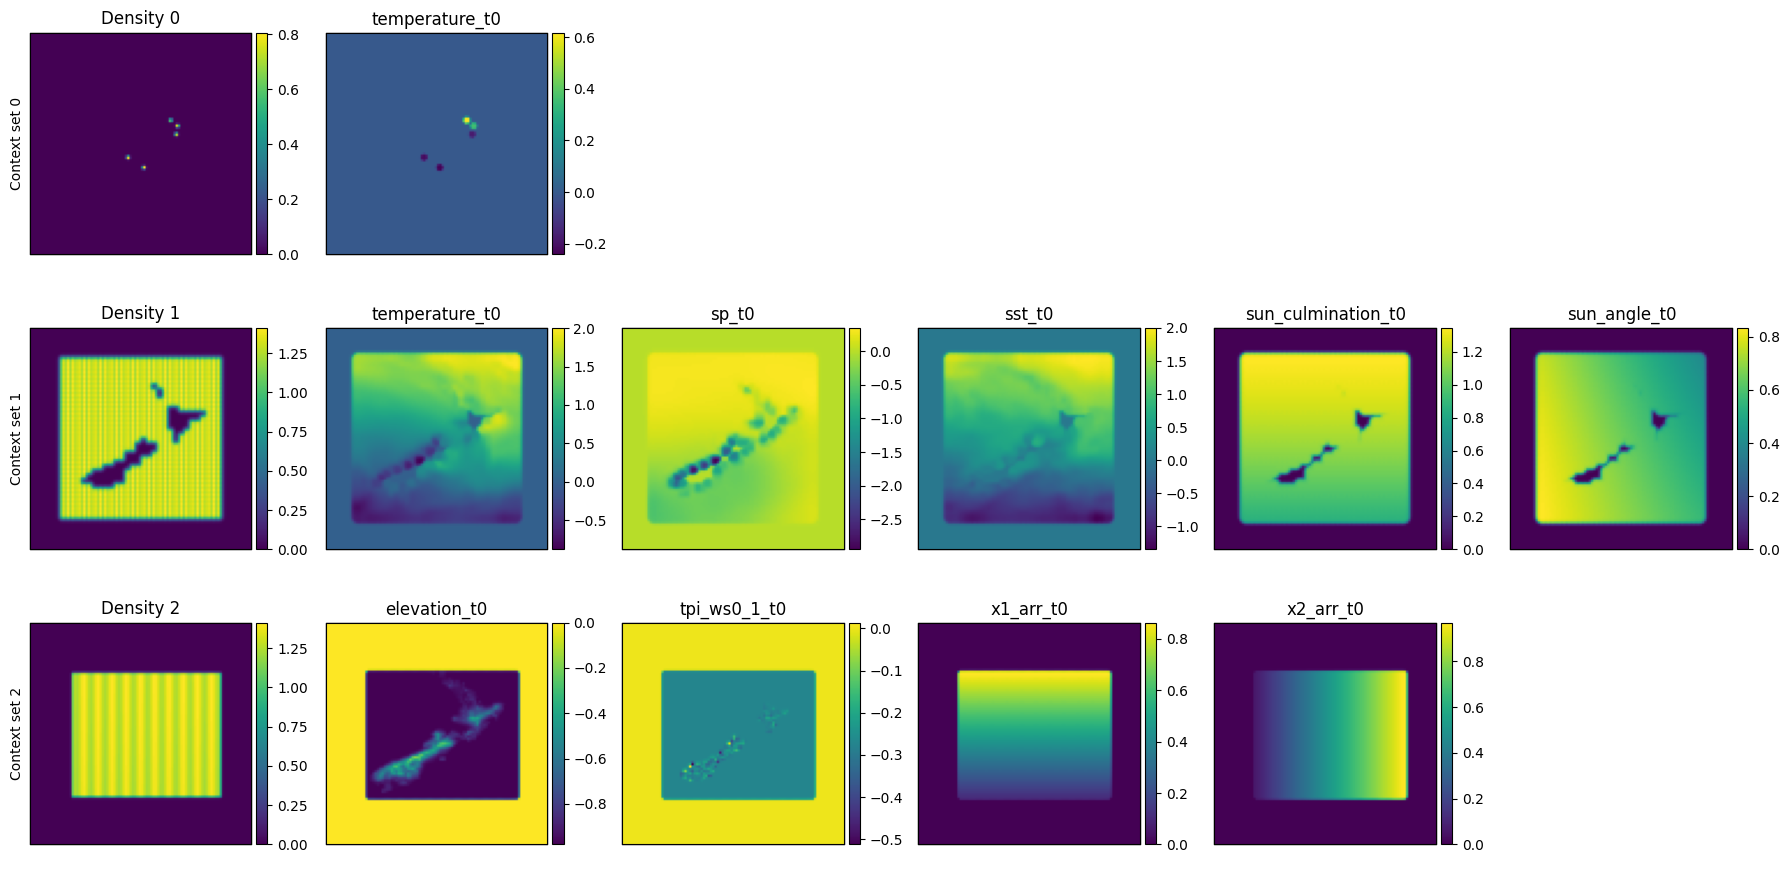

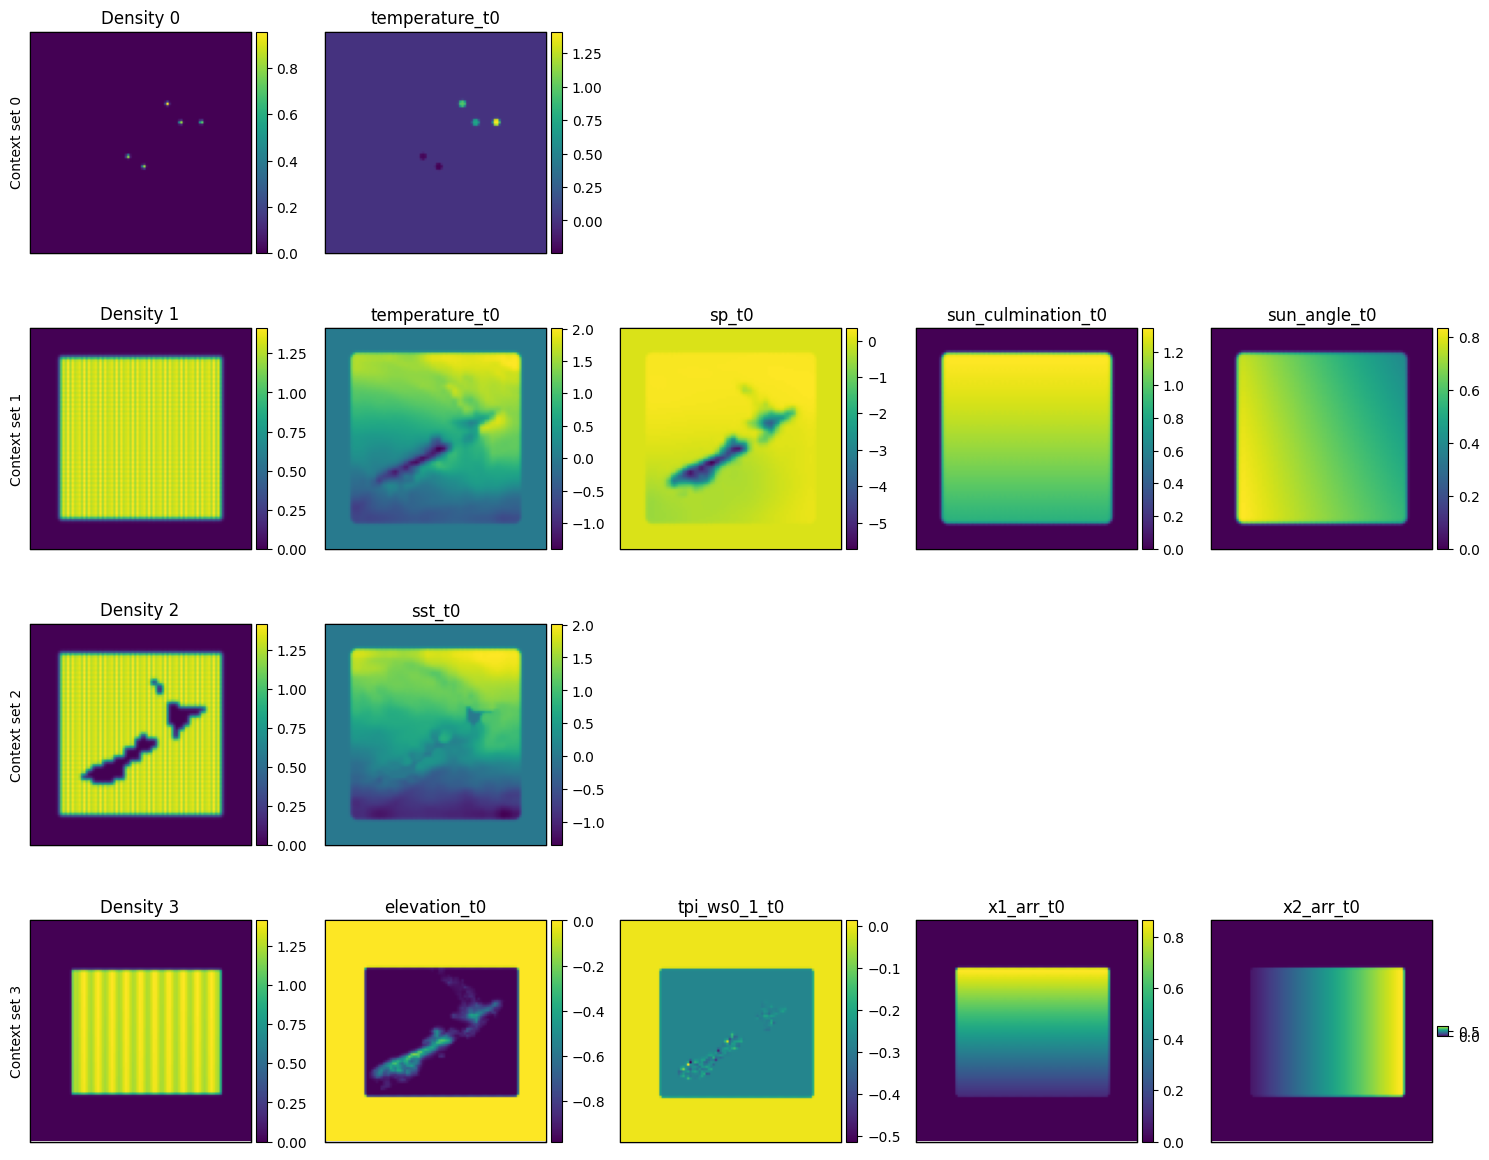

In [23]:
# there are missing values represented as NaNs in the SST context data
sst_frame_1 = train_tasks[1]['Y_c'][1][2]
print(np.any(np.isnan(sst_frame_1))) # are there any NaNs?
plt.imshow(np.isnan(sst_frame_1)) # plot the NaNs
plt.show()

In [16]:
task.remove_context_nans()

time: Timestamp/2014-01-01 06:00:00
ops: ['str/context_nans_removed']
X_c: ['ndarray/float32/(2, 5)', 'ndarray/float32/(2, 998)', ('ndarray/float32/(1, 54)', 'ndarray/float32/(1, 54)')]
Y_c: ['ndarray/float32/(1, 5)', 'ndarray/float32/(5, 998)', 'ndarray/float32/(4, 54, 54)']
X_t: ['ndarray/float32/(2, 5)']
Y_t: ['ndarray/float32/(1, 5)']
Y_t_aux: ndarray/float32/(2, 5)

In [17]:
print(np.any(np.isnan(task['Y_c'][1][2]))) # .remove_context_nans worked to remove NaNs

False


In [18]:
# however the model's context encoding still removes values at those locations across all channels in context set 1
plot= deepsensor.plot.context_encoding(model, task, task_loader)
plot.show()

`mask_nans_numpy()`

In [19]:
task = deepcopy(train_tasks[1])
task = task.add_batch_dim().mask_nans_numpy()
plot= deepsensor.plot.context_encoding(model, task, task_loader)
plot.show()

Ideal bevaviour would be having a mask (density channel) for just the channel with missing data and also a mask for other channels without missing data. This can be achieved be simply moving the channel with missing data into a different context set. We should see what actual implications this has on the model structure.

In [20]:
era5_missing = era5_ds_coarsen[SEA_SURFACE_TEMPERATURE]
era5_ds_coarsen = era5_ds_coarsen.drop_vars(SEA_SURFACE_TEMPERATURE)

In [21]:
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))
era5_processed, era5_missing_processed, station_processed = data_processor([era5_ds_coarsen, era5_missing, stations_resample])
ds_aux_processed, ds_aux_coarse_processed = data_processor([ds_aux, ds_aux_coarse], method='min_max')

x1x2_ds = construct_x1x2_ds(ds_aux_coarse_processed)
ds_aux_coarse_processed['x1_arr'] = x1x2_ds['x1_arr']
ds_aux_coarse_processed['x2_arr'] = x1x2_ds['x2_arr']

task_loader = TaskLoader(
        context = [station_processed, era5_processed, era5_missing_processed, ds_aux_coarse_processed], 
        target = station_processed, 
        aux_at_targets = ds_aux_processed, 
        links = [(0, 0)])

# build a model - necessary to visualise context encodings
# we won't train it in this experiment
model = ConvNP(data_processor, task_loader, unet_channels=(64,)*5, likelihood="gnp")

# build a set of tasks to investigate
train_dates = era5_ds.sel(time=slice("2014-01-01", "2014-12-31")).time.values

train_tasks_missing_split = []
for date in train_dates:
    task = task_loader(date, context_sampling=["split", "all", "all", "all"], target_sampling=["split"], split_frac=0.5)
    train_tasks_missing_split.append(task)

/home/lennoxc/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"x1_map={x1_map} and x2_map={x2_map} have different ranges ({float(np.diff(x1_map))} "
/home/lennoxc/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"and {float(np.diff(x2_map))}, respectively). "
/home/lennoxc/niwa/convcnp-assim-nz/venv/src/deepsensor/deepsensor/data/processor.py:128: UserWarning: x1_map=(-50.0, -32.0) and x2_map=(165.0, 180.0) have different ranges (18.0 and 15.0, respectively). This can lead to stretching/squas

dim_yc inferred from TaskLoader: (1, 4, 1, 4)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 2
Setting aux_t_mlp_layers: (64, 64, 64)
internal_density inferred from TaskLoader: 70
encoder_scales inferred from TaskLoader: [0.007142857142857143, 0.01388888992369175, 0.01388888992369175, 0.007111109793186188]
decoder_scale inferred from TaskLoader: 0.014285714285714285


In [22]:
plot = deepsensor.plot.context_encoding(model, train_tasks_missing_split[1], task_loader)

In [ ]:
len(model.model.encoder.coder[2]) # the model now has four set convs

4

In [ ]:
# the unet structure is still the same
model.model.decoder

Chain(
    UNet(
      (before_turn_layers): ModuleList(
        (0): Conv2d(14, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1-4): 4 x Sequential(
          (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
      )
      (after_turn_layers): ModuleList(
        (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1-3): 3 x Sequential(
          (0): Upsample(scale_factor=2.0, mode='bilinear')
          (1): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        )
        (4): Sequential(
          (0): Upsample(scale_factor=2.0, mode='bilinear')
          (1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        )
      )
      (final_linear): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    ),
    RepeatForAggregateInputs(
      (coder): Chain(
          SetConv(),
          _LambdaModule(),
          

In [35]:
task = deepcopy(train_tasks_missing_split[1])

In [36]:
task

time: Timestamp/2014-01-01 06:00:00
ops: []
X_c: ['ndarray/float32/(2, 5)', ('ndarray/float32/(1, 36)', 'ndarray/float32/(1, 30)'), ('ndarray/float32/(1, 36)', 'ndarray/float32/(1, 30)'), ('ndarray/float32/(1, 54)', 'ndarray/float32/(1, 54)')]
Y_c: ['ndarray/float32/(1, 5)', 'ndarray/float32/(4, 36, 30)', 'ndarray/float32/(1, 36, 30)', 'ndarray/float32/(4, 54, 54)']
X_t: ['ndarray/float32/(2, 5)']
Y_t: ['ndarray/float32/(1, 5)']
Y_t_aux: ndarray/float32/(2, 5)

Overall the task has a similar structure, just with slightly more overhead for the extra context set.

This architecture could get cumbersome if there are many channels which may contain missing data, but this is not a bad solution as all the necessary information is retained. After mapping onto the internal grid, the model strucutre is unchanged (i.e. the decoder component) as the internal grid simply has 14 channels. We know that transfer learning can adapt to different numbers of channels by copying the majority of the Unet weights. There aren't many learnable parameters in the encoder structure so this can be re-trained if required. Transfer learning should attempt to use similar inputs layers as what will be used in the final model. But if there are small differences, the model should be able to adapt.